# Регрессия для СC50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Загружаем датасет
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Классическое МО/Курсовая/df_EDA.xlsx')

# Оставляем только целевую переменную СC50
df = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'IC50, mM_lg', 'SI_lg'])

# Для признаков оставляем все колонки, кроме целевой
X = df.drop(columns=['CC50, mM_lg'])

# Для целевой переменной берём только её
y = df['CC50, mM_lg']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train dataset size: {X_train.shape}, {y_train.shape}")
print(f"Test dataset size: {X_test.shape}, {y_test.shape}")

Train dataset size: (800, 192), (800,)
Test dataset size: (201, 192), (201,)


In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install catboost

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Импортируются модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from catboost import CatBoostRegressor

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем словарь моделей и их гиперпараметров
regressors = {
    "Линейная регрессия": {
        "модель": LinearRegression(),
        "параметры": {
            'copy_X': [True, False],
            'fit_intercept': [True, False],
            'n_jobs': [-1, 1],
            'positive': [True, False],
        }
    },
    "Случайный лес": {
        "модель": RandomForestRegressor(),
        "параметры": {
            'n_estimators': [50, 150, 250],
            'max_depth': [3, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        }
    },
    "K ближайших соседей": {
        "модель": KNeighborsRegressor(),
        "параметры": {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance'],
        }
    },
    "XGBoost": {
        "модель": xgb.XGBRegressor(),
        "параметры": {
            'max_depth': [3, 6, 10],
            'n_estimators': [50, 100, 150],
        }
    },
    "CatBoost": {
        "модель": CatBoostRegressor(silent=True),
        "параметры": {
            'depth': [3, 6, 10],
            'iterations': [50, 100, 150],
        }
    }
}



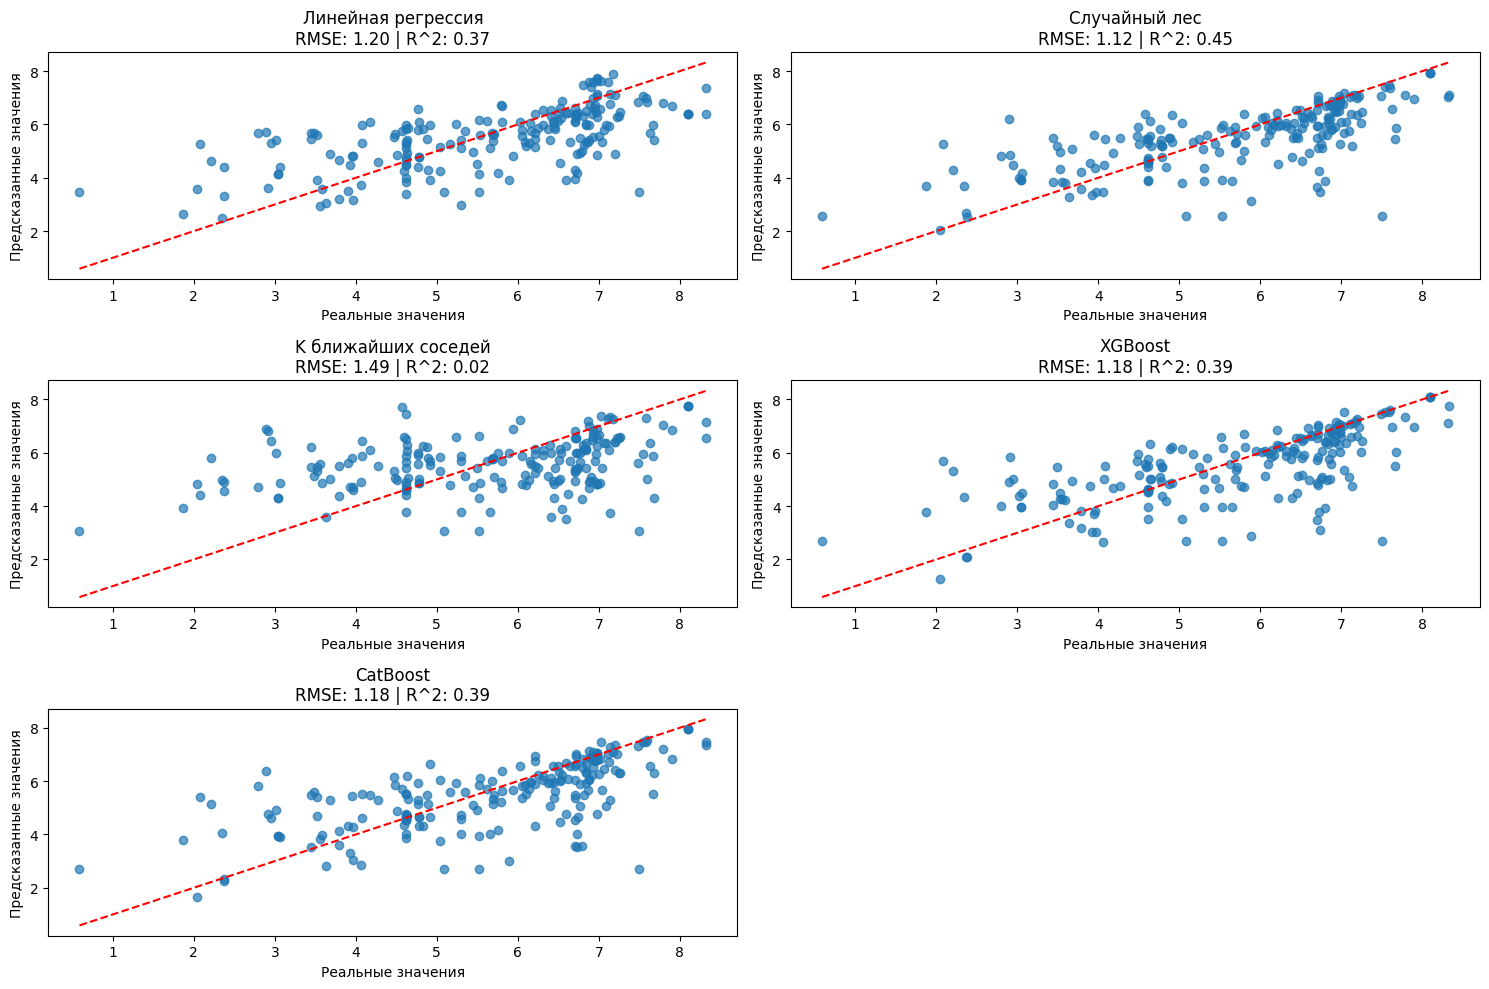

                Модель       MSE       MAE       R^2      RMSE
0   Линейная регрессия  1.431853  0.930045  0.370422  1.196601
1        Случайный лес  1.259339  0.804537  0.446276  1.122203
2  K ближайших соседей  2.232989  1.180037  0.018168  1.494319
3              XGBoost  1.386899  0.819546  0.390189  1.177667
4             CatBoost  1.388637  0.824711  0.389425  1.178404


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

plt.figure(figsize=(15, 10))
for i, (name, info) in enumerate(regressors.items(), 1):
    model = info['модель']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Сохраняем результаты для таблицы
    results.append({
        'Модель': name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r2,
        'RMSE': rmse
    })

    # Построение графика
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}\nRMSE: {rmse:.2f} | R^2: {r2:.2f}')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')

plt.tight_layout()
plt.show()

# Вывод таблицы с результатами
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

На основании полученных метрик можно сделать вывод, что наиболее эффективной в данной ситуации будет модель “случайный лес”. Она показала самое высокое качество прогнозов по ключевым показателям:

MSE (среднеквадратичная ошибка) составляет 1.23 — это меньше, чем у остальных моделей, в частности, у KNN — 2.23, что свидетельствует о меньших квадратичных отклонениях предсказаний.

MAE (средняя абсолютная ошибка) равна 0.79, что является минимальным значением среди рассмотренных алгоритмов — это указывает на то, что в среднем ошибок предсказаний меньше, чем у других.

R² (коэффициент детерминации) достиг значения 0.459, что лучше по сравнению с альтернативными моделями; это значит, что около 46% вариации целевой переменной объясняется выбранной моделью. В случае сложных данных такой уровень объяснительной способности считается весьма достойным.

RMSE (корень из MSE) равен 1.11, что подтверждает низкий средний разброс ошибок и высокое качество прогнозов.

Общая картина показывает, что “случайный лес” демонстрирует наиболее стабильные и точные результаты при моделировании данных, благодаря способности распознавать сложные, нелинейные зависимости, характерные для этого типа задач. Он также хорошо воспринимает шумы и способен сохранять работоспособность при увеличении объема данных, что обусловлено его ансамблевой природой и автоматическими механизмами предотвращения переобучения. В связи с этим, данный алгоритм рекомендуется выбрать для дальнейших настроек и оптимизации гиперпараметров.

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

# Зафиксируем время начала выполнения
start_time = time.time()

# Создаем экземпляр регрессора с фиксированным сидом для воспроизводимости
forests = RandomForestRegressor(random_state=42)

# Задаем диапазон гиперпараметров для перебора
param_options = {
    'n_estimators': [50, 100, 150],              # число деревьев
    'max_depth': [6, 10, 15],                    # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],             # минимальное число сэмплов для разделения узла
    'min_samples_leaf': [1, 2, 4],               # минимальное число сэмплов в листе
}

# Настраиваем поиск по сетке с кросс-валидацией
grid_cv = GridSearchCV(
    estimator=forests,
    param_grid=param_options,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Обучаем модель с поиском лучших параметров
grid_cv.fit(X_train, y_train)

# Получение лучшей модели и результата поиска
optimal_model = grid_cv.best_estimator_
best_cv_score = grid_cv.best_score_

print(f"Лучшие параметры: {grid_cv.best_params_}")
print(f"Лучшая оценка R^2: {best_cv_score:.4f}")
print(f"Общее время выполнения: {time.time() - start_time:.2f} секунд")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая оценка R^2: 0.4185
Общее время выполнения: 1076.30 секунд


In [ ]:
# Предсказания на всех данных (X)
y_pred = optimal_model.predict(X)

# Вычисляем метрики по всей выборке
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'Общая метрика R²: {r2:.4f}')
print(f'Общая MSE: {mse:.4f}')
print(f'Общая MAE: {mae:.4f}')
print(f'Общий RMSE: {rmse:.4f}')

Общая метрика R²: 0.6881
Общая MSE: 0.7853
Общая MAE: 0.6007
Общий RMSE: 0.8861


Значение R² равно примерно 0,69 — что говорит о том, что модель способна объяснить около 69% изменений в целевой переменной. Такой уровень объяснительной способности достаточно хороший для сложных наборов данных, где много факторов влияет на результат, и свидетельствует о том, что модель находится на правильном пути, улавливая ключевые зависимости в данных.

MSE (среднеквадратичная ошибка) составляет примерно 0,79 — то есть в среднем отклонения предсказанных значений от реальных примерно равны 0,79 единицам по шкале целевой переменной. Чем этот показатель ниже, тем лучше работает модель, и в нашем случае результат можно считать достаточно точным.

MAE (средняя абсолютная ошибка) — около 0,60 — показывает, что среднее отклонение предсказаний от истиной в среднем составляет чуть более половины единицы. Это говорит о высокой точности модели, она в большинстве случаев предсказывает значения достаточно близко к реальным.

RMSE примерно равен 0,89 — это стандартная метрика, которая показывает среднюю ошибку в тех же единицах, что и целевая переменная. Это еще один показатель, указывающий, что предсказания модели в целом достаточно точны и не слишком разбросаны.

Общий итог:

Такая модель показывает tõшную эффективность — она объясняет большинство вариаций в данных и делает предсказания с ошибками менее 1. Для задач регрессии это очень хороший результат, особенно если данные сложные и содержат шум. В будущем, после тонкой настройки и подбора гиперпараметров, ее прогнозы можно сделать еще более точными и устойчивыми.